In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/e-commerce-products-search-engine-recommendation/data.csv
/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2/saved_model.pb
/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2/variables/variables.index
/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2/variables/variables.data-00000-of-00001


In [2]:
!pip install thefuzz

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
from thefuzz import fuzz, process

In [4]:
# laoding the dataset
df = pd.read_csv("/kaggle/input/e-commerce-products-search-engine-recommendation/data.csv")

# setting the index by product's id
df = df.set_index("id")

# print the shape of dataframe
print(df.shape)

# showing 5 random samples
df.sample(5)

(1666, 21)


,slug,title,imgs,brand,category,vendor,used,address,availability,currency,...,discounted_price,specifications,description,delivery_fee,delivery_details,warranty,warranty_type,average_rating,num_ratings,reviews
id,,,,,,,,,,,,,,,,,,,,,
1390,https://priceoye.pk/mobiles/vivo/vivo-y02s,Vivo Y02s,['https://images.priceoye.pk/vivo-y02s-pakista...,NaN,Mobile,PriceOye,0,NaN,Avaiable,PKR,...,42399.0,"{'Release Date': '2022-11-30', 'SIM Support': ...",NaN,NaN,NaN,NaN,NaN,5.0,2.0,['3rd Oder Received from Priceoye in Just 2 Mo...
414,https://www.czone.com.pk/laptops-apple-laptops...,"Czone.com.pk: Apple MacBook Air 13.3"" MGNE3 M1...",['https://www.czone.com.pk/images/thumbnails-l...,Apple,Laptop,ComputerZone,0,"FL 4/20, Main Rashid Minhas Road, Gulshan-e-Iq...",Available on Order,PKR,...,NaN,"{'Processor Type': 'Apple M1 8-Core CPU', 'Ins...","Apple MacBook Air 13.3"" M1 Chip MGNE3 Gold 8GB...",NaN,NaN,NaN,International Warranty,NaN,NaN,[]
596,https://www.techglobe.pk/laptops/microsoft/mic...,Microsoft Surface Pro 9 12th Gen Core i5-1235U...,['https://static3.webx.pk/files/4012/Images/Th...,Microsoft,Laptop,TechGlobe,0,NaN,NaN,PKR,...,NaN,{'Processor Type': '12th Generation Intel Core...,Microsoft Surface Pro 9 12th Gen Core i5-1235U...,NaN,NaN,1 year,International Warranty,NaN,NaN,[]
1028,https://priceoye.pk/wireless-earbuds/anker/ank...,Anker SoundCore Life Note Bluetooth Earphones,['https://images.priceoye.pk/anker-soundcore-l...,NaN,Earbuds,PriceOye,0,NaN,Not Available,PKR,...,7499.0,"{'Model': 'A3908H11', 'Waterproof': 'IPX5 (Wat...",NaN,NaN,NaN,NaN,NaN,5.0,3.0,['Really Good earphones at this price point al...
1126,https://priceoye.pk/wireless-earbuds/sony/sony...,Sony Wireless Headphones WH-CH510,['https://images.priceoye.pk/sony-wireless-hea...,NaN,Earbuds,PriceOye,0,NaN,Not Available,PKR,...,8699.0,"{'Model': 'WH-CH510', 'Waterproof': 'N/A', 'We...",NaN,NaN,NaN,NaN,NaN,5.0,1.0,[]


In [5]:
# columns that have been dumped as strings but are python lists and dictionaries
df['reviews'] = df['reviews'].fillna(str([])).map(eval)
df['imgs'] = df['imgs'].map(eval)
df['specifications'] = df['specifications'].map(eval)

In [6]:
# this function converts the row will all columns with unstructred data into plain sentences

def convert_to_sentences(row):
    sep = " __ "
    invalids = {"-", "N/A", "NA", "N\\A"}

    sents = []
    for k, v in row.items():

        if type(v) == list:
            if len(v) == 0: continue
            sent = k + " " + " ".join(v)

        elif type(v) == dict:
            if len(v) == 0: continue
            # sent = sep.join([f"{k2} {v2}" for k2, v2 in v.items() if v2 not in invalids])
            for k2, v2 in v.items():
                if v2 not in invalids:
                    sents.append(f"{k2} {v2}")
            continue

        else:
            if pd.isna(v): continue
            sent = f"{k} {v}"

        sent = sent.lower()
        sent = [i for i in sent.split(". ") if len(i) > 0]
        sents.extend(sent)

    return [i.lower() for i in sents]

convert_to_sentences(df.iloc[0])

['slug https://www.mega.pk/mobiles_products/23522/nothing-phone-1-8gb-ram-256gb-storage-non-pta-5g-black.html',
 'title nothing phone 1 8gb ram 256gb storage non pta 5g black ',
 'imgs https://www.mega.pk/items_images/nothing+phone+1+8gb+ram+256gb+storage+non+pta+5g+black+price+in+pakistan%2c+specifications%2c+features_-_23522.webp',
 'category mobile',
 'vendor mega.pk',
 'used 0',
 'address office 11, 12, 14 basement ahmed center, i-8 markaz, islamabad, pakistan',
 'currency pkr',
 'original_price 129999.0',
 'ram 8gb',
 'memory quantity ',
 'internal storage space 256gb',
 'main camera pixels 50 mp, f/1.9, 24mm (wide), 1/1.56',
 'battery capacity li-po 4500 mah, non-removable',
 'screen size 6.55 inches',
 '5g support yes',
 'finger print yes',
 'display technology oled, 1b colors, 120hz, hdr10+, 500 nits (typ), 700 nits (peak)',
 'display 6.55 inches oled, 1b colors',
 'number of colours 1b',
 'scratch resistant display ',
 'screen resolution 1080 x 2400 pixels',
 'pixel density 40

In [7]:
expanded_sentences = []
for i, row in df.iterrows():
    sent = convert_to_sentences(row)
    expanded_sentences.append(sent)
print("Total Sentences:", sum([len(i) for i in expanded_sentences]))

Total Sentences: 62170


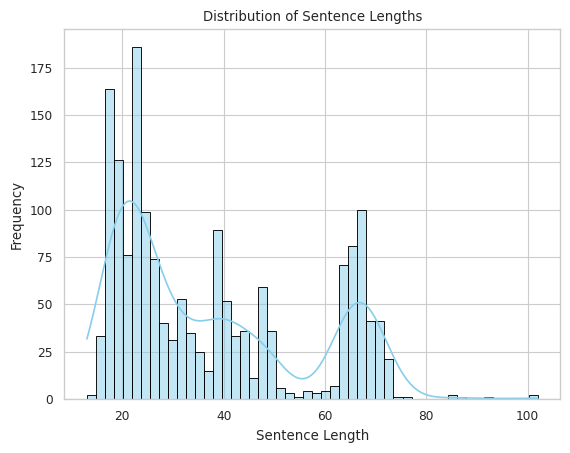

In [8]:
sns.set_style('whitegrid')
sns.set_context('paper')
sns.histplot(
    [len(i) for i in expanded_sentences],
    bins=50, kde=True, color='skyblue', edgecolor='black'
)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

In [9]:
linear_expanded_sentences = []
linear_ids = []
for sents, ids in zip(expanded_sentences, df.index):
    for sent in sents:
        linear_expanded_sentences.append(sent.lower())
        linear_ids.append(ids)
linear_expanded_sentences = np.array(linear_expanded_sentences)
linear_ids = np.array(linear_ids)

for _ in range(10):
    i = random.choice(range(len(linear_ids)))
    print("\nID:", linear_ids[i])
    print("Sentence:", linear_expanded_sentences[i])


ID: 287
Sentence: gaming machine no

ID: 744
Sentence: type of harddrive 512 gb pcie® nvme™ m.2 ssd

ID: 751
Sentence: dedicated graphics yes

ID: 13
Sentence: pta approved yes

ID: 24
Sentence: pixel density 496 ppi

ID: 185
Sentence: wifi (wireless fidelity) yes

ID: 235
Sentence: dimensions (wxhxd) 35.9 x 22.9 x 1.86 cm

ID: 1536
Sentence: screen resolution 320 x 240 pixels

ID: 186
Sentence: weight 2.20 kg

ID: 32
Sentence: chipset qualcomm sm8550-ab snapdragon 8 gen 2 (4 nm)


In [10]:
import tensorflow_hub as hub

use = hub.load("/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [11]:
vector = use(["this is a simple sentence"])
vector.dtype, vector.shape

(tf.float32, TensorShape([1, 512]))

In [12]:
vectors = use(linear_expanded_sentences).numpy()

vectors.shape

(62170, 512)

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
vectors = scaler.fit_transform(vectors)

In [14]:
def pipeline(texts):
    vector = use(texts).numpy()
    vector = scaler.transform(vector)
    return vector

In [15]:
query = "Gaming Laptops"
filters = {
    "RAM": "16GB",
    "": "SSD",
    "Brand": "Lenovo"
}

In [16]:
def preprocess_query(query, filters):
    return [query.lower()] + [f"{k} {v}".lower() for k, v in filters.items()]

queries = preprocess_query(query, filters)
queries

['gaming laptops', 'ram 16gb', ' ssd', 'brand lenovo']

In [17]:
encoded = pipeline(queries)
encoded

array([[0.53427017, 0.4755112 , 0.16422635, ..., 0.52300733, 0.6039705 ,
        0.45306522],
       [0.7538656 , 0.20048928, 0.62764955, ..., 0.41968122, 0.3415676 ,
        0.36976504],
       [0.5747614 , 0.31386918, 0.62619317, ..., 0.54749906, 0.4915955 ,
        0.43137476],
       [0.5771097 , 0.32892138, 0.36535925, ..., 0.79477453, 0.13041171,
        0.28280514]], dtype=float32)

In [18]:
from sklearn.metrics.pairwise import euclidean_distances
similarity_scores = - euclidean_distances(encoded, vectors)

similarity_scores

array([[-6.460191 , -6.0543633, -6.1653695, ..., -6.382967 , -6.9088693,
        -6.489845 ],
       [-6.1571374, -4.8011475, -6.1671014, ..., -6.193946 , -6.261703 ,
        -6.1348724],
       [-5.884188 , -5.6958184, -6.1175466, ..., -5.908045 , -6.4094462,
        -5.862071 ],
       [-6.2272916, -6.0107656, -5.955142 , ..., -5.8733945, -6.3159995,
        -6.3620095]], dtype=float32)

In [19]:
idx = np.argsort(
    - similarity_scores.mean(axis=0)
)
idx = idx[:50]

In [20]:
ids = linear_ids[idx]
ids

array([194, 755, 635, 711, 386, 312, 708, 711, 767, 222, 553, 375, 767,
       708, 201, 216, 549, 176, 221, 245, 555, 260, 747, 747, 192, 298,
       348, 638, 582, 223, 217, 227, 225, 754, 299, 736, 736, 591, 370,
       754, 547, 420, 193, 224, 579, 401, 592, 273, 746, 340])

In [21]:
products = df.loc[ids]
products.head()

,slug,title,imgs,brand,category,vendor,used,address,availability,currency,...,discounted_price,specifications,description,delivery_fee,delivery_details,warranty,warranty_type,average_rating,num_ratings,reviews
id,,,,,,,,,,,,,,,,,,,,,
194,https://www.mega.pk/laptop_products/24384/Leno...,Lenovo V15 G2 Core i3 11th Generation 4GB RAM ...,[https://www.mega.pk/items_images/Lenovo+V15+G...,Lenovo,Laptop,MEGA.PK,0,"Office 11, 12, 14 Basement Ahmed Center, I-8 M...",NaN,PKR,...,NaN,{'Processor': 'Core i3 11th Generation i3-1115...,NaN,NaN,NaN,1 year,NaN,NaN,NaN,[]
755,https://www.paklap.pk/lenovo-ideapad-3-intel-c...,Lenovo IdeaPad 3 Celeron,[https://www.paklap.pk/media/catalog/product/c...,Lenovo,Laptop,Paklap,1,NaN,NaN,PKR,...,NaN,"{'Brand': 'Lenovo', 'Processor': 'Core i3 ( 1s...",NaN,0.0,NaN,15 days,NaN,NaN,NaN,[]
635,https://www.techglobe.pk/laptops/lenovo/lenovo...,Lenovo Legion 5i 12th Gen Core i7-12700H RTX30...,[https://static3.webx.pk/files/4012/Images/Thu...,Lenovo,Laptop,TechGlobe,0,NaN,NaN,PKR,...,NaN,{'Processor Type': '12th Generation Intel Core...,Lenovo Legion 5i Gaming 12th Gen Core i7-12700...,NaN,NaN,1 year,International Warranty,NaN,NaN,[]
711,https://www.paklap.pk/lenovo-thinkbook-14-g2-c...,Lenovo ThinkBook G2 Ci5,[https://www.paklap.pk/media/catalog/product/c...,Lenovo,Laptop,Paklap,0,NaN,NaN,PKR,...,NaN,"{'Brand': 'Lenovo', 'Generation': '11th Genera...",NaN,0.0,NaN,NaN,International Warranty,NaN,NaN,[]
386,https://www.czone.com.pk/laptops-lenovo-laptop...,Lenovo IdeaPad 3 15IAU7 Laptop - Intel Core i7,[https://www.czone.com.pk/images/thumbnails-la...,Lenovo,Laptop,ComputerZone,0,"FL 4/20, Main Rashid Minhas Road, Gulshan-e-Iq...",Not Available,PKR,...,NaN,{'Processor Type': '12th Generation Intel Core...,Lenovo IdeaPad 3 15IAU7 Laptop - Intel Core i7...,NaN,NaN,NaN,International Warranty,NaN,NaN,[]


In [22]:
def get_fuzzy_score(row, query):
    
    query = query.lower()
    method = lambda x: fuzz.partial_ratio(query, x.lower())
    
    best_score = -1
    
    for k, v in row.items():
        if type(v) == list:
            if len(v) == 0: continue
            for item in v:
                best_score = max(best_score, method(item))

        elif type(v) == dict:
            if len(v) == 0: continue
            for k2, v2 in v.items():
                best_score = max(best_score, method(f"{k2} {v2}"))

        elif not pd.isna(v):
            best_score = max(best_score, method(f"{k} {v}"))

    return best_score

get_fuzzy_score(df.iloc[400], "laptop")

100

In [23]:
scores_mat = []
for q in queries:
    scores_k = []
    for i, product in products.iterrows():
        s = get_fuzzy_score(product, q)
        scores_k.append(s)
    scores_mat.append(scores_k)
idx = np.argsort(-np.array(scores_mat).mean(axis=0))
products = products.iloc[idx]

In [24]:
print("Query:", query)
print("Filters", filters)

Query: Gaming Laptops
Filters {'RAM': '16GB', '': 'SSD', 'Brand': 'Lenovo'}


In [25]:
print("Products Sorted on base of relevance to query:")
products[['title', 'specifications', 'description']].head(20)

Products Sorted on base of relevance to query:


,title,specifications,description
id,,,
638,Lenovo Legion Slim 5 16IRH8 13th Gen Core i7-1...,{'Processor Type': '13th Generation Intel Core...,Lenovo Legion Slim 5 16IRH8 Gaming Laptop 13th...
754,Lenovo LEGION 7 RTX 3070Ti,"{'Brand': 'Lenovo', 'Generation': '12th Genera...",NaN
746,Lenovo Legion 5 Ryzen 7,"{'Brand': 'Lenovo', 'Generation': 'AMD', 'Proc...",NaN
747,Lenovo LEGION 5 - Alder Lake - 12th Gen Core i...,"{'Brand': 'Lenovo', 'Generation': '12th Genera...",NaN
754,Lenovo LEGION 7 RTX 3070Ti,"{'Brand': 'Lenovo', 'Generation': '12th Genera...",NaN
747,Lenovo LEGION 5 - Alder Lake - 12th Gen Core i...,"{'Brand': 'Lenovo', 'Generation': '12th Genera...",NaN
420,"Lenovo Yoga 7i 14"" 2.2K Touchscreen 2-in-1 Laptop",{'Processor Type': 'Intel Core i7-1255U Proces...,"Lenovo Yoga 7i 14"" 2.2K Touchscreen 2-in-1 Lap..."
340,Lenovo Legion 5 Core i7 12th Generation 16GB R...,{'Processor': 'Core i7 12th Generation i7-1270...,NaN
222,Lenovo ThinkPad X1 Carbon Gen 10 Core i7 12th ...,{'Processor': 'Core i7 12th Generation i7-1270...,NaN
